In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/MLEng/Projects/semantic-segmentation-floodnet')

In [3]:
%cd /content/drive/MyDrive/MLEng/Projects/semantic-segmentation-floodnet

/content/drive/MyDrive/MLEng/Projects/semantic-segmentation-floodnet


In [4]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 90.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=b162524bc72b6a3c321c32c06df14975670d4b1edabe6d51a84022f8822905e3
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=53fcd93b3821a906751874e889c7f635e921d63bfabfb60c9e5cf04480218155
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f53

In [6]:
# Image size taken from FloodNet paper for segmentation task
# IMG_SIZE = 713 -- This didn't work for some reason: RuntimeError: Wrong input shape height=713, width=713. Expected image height and width divisible by 8. Consider pad your images to shape (720, 720).
IMG_SIZE = 256

DATA_DIR = '/content/drive/MyDrive/MLEng/Projects/semantic-segmentation-floodnet/FloodNet-Supervised_v1.0'

DEVICE = 'cuda'
EPOCHS = 5
LR = 0.003
BATCH_SIZE = 16

# PSPNet, ResNet101 as backbone with imagenet weights, from FloodNet paper
# Use resnet18 initially for speed,
ENCODER = 'resnet18'
WEIGHTS = 'imagenet'
ACTIVATION = None

class_labels = {0: 'Background',
                1: 'Building-flooded',
                2: 'Building-non-flooded',
                3: 'Road-flooded',
                4: 'Road-non-flooded',
                5: 'Water',
                6: 'Tree',
                7: 'Vehicle',
                8: 'Pool',
                9: 'Grass'}

CLASSES = [v for v in class_labels.values()]

In [5]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

import albumentations as A
import torch

from tqdm import tqdm

avail = torch.cuda.is_available()
dev_count = torch.cuda.device_count()
dev_name = torch.cuda.get_device_name(0)
print(f"Available: {avail}; Count: {dev_count}; Name: {dev_name}")

Available: True; Count: 1; Name: Tesla T4


In [7]:
train_df = pd.read_csv('train.csv')
valid_df = pd.read_csv('val.csv')
train_df.head()

,images,masks
0,/content/drive/MyDrive/MLEng/Projects/semantic...,/content/drive/MyDrive/MLEng/Projects/semantic...
1,/content/drive/MyDrive/MLEng/Projects/semantic...,/content/drive/MyDrive/MLEng/Projects/semantic...
2,/content/drive/MyDrive/MLEng/Projects/semantic...,/content/drive/MyDrive/MLEng/Projects/semantic...
3,/content/drive/MyDrive/MLEng/Projects/semantic...,/content/drive/MyDrive/MLEng/Projects/semantic...
4,/content/drive/MyDrive/MLEng/Projects/semantic...,/content/drive/MyDrive/MLEng/Projects/semantic...


In [73]:
row = train_df.iloc[39]

image_path = row['images']
mask_path = row['masks']

image = cv2.imread(image_path)
# Matplotlib expects RGB but OpenCV provides it in BGR
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Explicitly set to grayscale and normalize
mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
# / 255.0

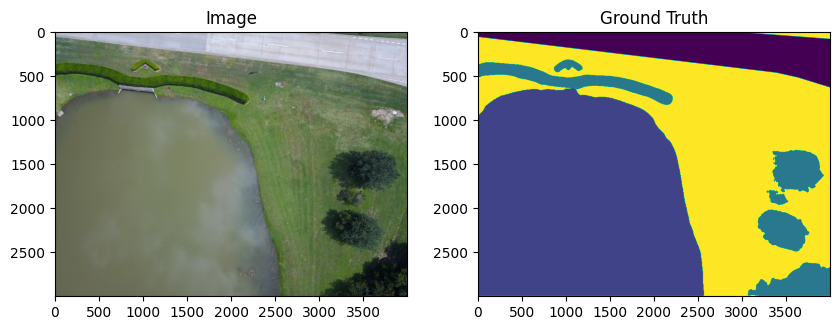

In [74]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].set_title('Image')
ax[0].imshow(image)

ax[1].set_title('Ground Truth')
ax[1].imshow(mask, cmap=None);

In [51]:
train_transforms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5)
                    ], is_check_shapes=False)

valid_transforms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE)
    ], is_check_shapes=False)


In [11]:
from torch.utils.data import Dataset

In [52]:
class SegmentationDataset(Dataset):

    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        image_path = row['images']
        mask_path = row['masks']

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype('uint8')

        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        # mask is in two dimensions so expand this to include a single channel: (h, w) -> (h, w, c)
        mask = np.expand_dims(mask, axis=-1)

        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image = data['image']
            mask = data['mask']

        # PyTorch uses (c, h, w) so we transpose from (h, w, c)
        image = np.transpose(image, (2,0,1)).astype(np.float32)
        mask = np.transpose(mask, (2,0,1))

        image = torch.Tensor(image) / 255.0
        mask = torch.Tensor(mask).long()
        # mask = torch.round(torch.Tensor(mask) / 255.0)

        return image, mask

In [53]:
train = SegmentationDataset(train_df, train_transforms)
valid = SegmentationDataset(valid_df, valid_transforms)

print(f"Number of training samples: {len(train_df)}; number of validation samples: {len(valid_df)}")

Number of training samples: 1445; number of validation samples: 450


In [21]:
from torch.utils.data import DataLoader

In [90]:
BATCH_SIZE = 8
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=False)
valid_loader = DataLoader(valid, batch_size=BATCH_SIZE, shuffle=False)

In [91]:
counter = 0
df = train_df.iloc[counter:].copy()
sd = SegmentationDataset(df, train_transforms)
dl = DataLoader(sd, batch_size=BATCH_SIZE, shuffle=True)

# df['images'].str.extract(r'\/(\d{4})\.jpg$')
for b in train_loader:
  print(f"Image {counter} OK")
  counter += 1

Image 0 OK
Image 1 OK
Image 2 OK
Image 3 OK
Image 4 OK


ValueError: ignored

In [62]:
train_df.iloc[0]['images'].split('/')[-1].split('.')[0]

'6463'

In [27]:
images, labels = next(iter(train_loader))
print(images.shape, labels.shape, type(images), type(labels), images.dtype, labels.dtype)


torch.Size([16, 3, 256, 256]) torch.Size([16, 1, 256, 256]) <class 'torch.Tensor'> <class 'torch.Tensor'> torch.float32 torch.int64


In [28]:
test_img = images[10]
test_mask = labels[10]
print(test_img.shape, test_img.dtype, type(test_img),
      test_mask.shape, test_mask.dtype, type(test_img),
      test_img.max(), test_img.min(),
      test_mask.max(), test_mask.min(),
      sep='\n')

torch.Size([3, 256, 256])
torch.float32
<class 'torch.Tensor'>
torch.Size([1, 256, 256])
torch.int64
<class 'torch.Tensor'>
tensor(0.8863)
tensor(0.)
tensor(9)
tensor(4)


In [42]:
test_img.shape[:2]

torch.Size([3, 256])

In [92]:
torch.__version__

'2.1.0+cu118'

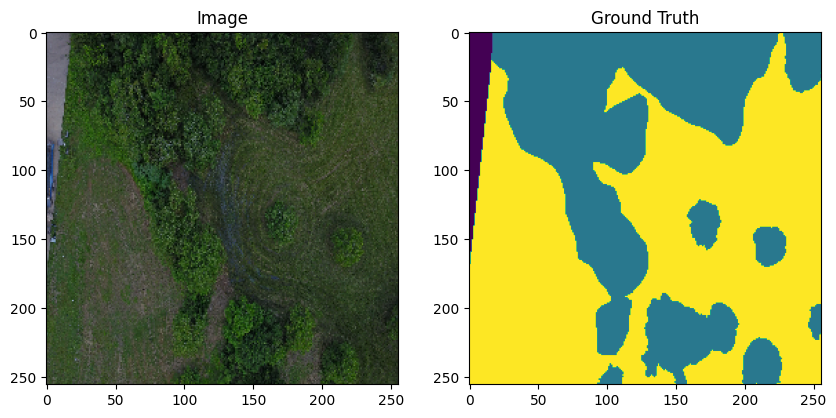

In [32]:
# plt.imshow(test_mask.permute(1,2,0));

fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].set_title('Image')
ax[0].imshow(test_img.permute(1,2,0))

ax[1].set_title('Ground Truth')
ax[1].imshow(test_mask.permute(1,2,0), cmap=None);

In [34]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [43]:
class SegmentationModel(nn.Module):

    def __init__(self):
        super(SegmentationModel, self).__init__()
        # smp.PSPNet
        self.arc = smp.UnetPlusPlus(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3,
        classes=len(CLASSES),
        activation=ACTIVATION
        )

    def forward(self, images, masks=None):

        logits = self.arc(images)

        if masks != None:
            loss1 = DiceLoss(mode='multiclass')(logits, masks)
            # loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            # return logits, loss1 + loss2
            return logits, loss1

        return logits

In [44]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): UnetPlusPlus(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        

In [45]:
def train(data_loader, model, optimizer):

    model.train()
    total_loss = 0.0

    for images, masks in tqdm(data_loader):

        images, masks = images.to(DEVICE), masks.to(DEVICE)

        optimizer.zero_grad()

        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

def valid(data_loader, model):

    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for images, masks in tqdm(data_loader):

            images, masks = images.to(DEVICE), masks.to(DEVICE)

            logits, loss = model(images, masks)

            total_loss += loss.item()

    return total_loss / len(data_loader)

In [39]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [46]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

    train_loss = train(train_loader, model, optimizer)
    valid_loss = valid(valid_loader, model)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        print('MODEL SAVED')
        best_valid_loss = valid_loss

    print(f"Epoch : {i+1} Train_loss: {train_loss} Valid_loss: {valid_loss}")

  9%|▉         | 8/91 [06:36<1:08:38, 49.62s/it]


ValueError: ignored